In [1]:
import pyabc
from pyabc import ABCSMC
from slad import *
import sklearn.gaussian_process as skl_gp
import logging

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

problem = FearnheadLVProblem()

pre = problem.get_sumstat()

distances = [
    pyabc.PNormDistance(sumstat=pre),
    pyabc.AdaptivePNormDistance(n_fit_scales=1, scale_function=pyabc.distance.root_mean_square_deviation, sumstat=pre),
    pyabc.AdaptivePNormDistance(scale_function=pyabc.distance.root_mean_square_deviation, sumstat=pre),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=False, normalize_labels=False, pre=pre)),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=True, pre=pre)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=True, n_fit=4, pre=pre)),
    pyabc.PNormDistance(sumstat=pyabc.LassoPredictorSumstat(pre=pre, alpha=0.01)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.LassoPredictorSumstat(n_fit=4, pre=pre, alpha=0.01)),
    pyabc.PNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=False), n_restarts_optimizer=2, pre=pre)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=False), n_restarts_optimizer=2, pre=pre)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=False), n_restarts_optimizer=2, n_fit=4, pre=pre)),
    #pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=True), n_fit=4, joint=False)),
    #pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['Matern', 'WhiteKernel'], ard=True), n_fit=4)),
    pyabc.PNormDistance(sumstat=pyabc.MLPPredictorSumstat(pre=pre)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.MLPPredictorSumstat(n_fit=4, pre=pre)),
    pyabc.PNormDistance(sumstat=pyabc.PredictorSumstat(
        predictor=pyabc.ModelSelectionPredictor(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=False)), pyabc.MLPPredictor()]
        ),
        n_fit=1,
        pre=pre,
    )),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.PredictorSumstat(
        predictor=pyabc.ModelSelectionPredictor(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=False)), pyabc.MLPPredictor()]
        ),
        n_fit=4,
        pre=pre,
    )),
    pyabc.distance.InfoWeightedPNormDistance(predictor=pyabc.ModelSelectionPredictor(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=False)), pyabc.MLPPredictor()]
        ),
        n_fit_info=4,
        sumstat=pre,
    ),
]

labels = [
    'Euclidean',
    'Calibrated Euclidean',
    'Adaptive Euclidean',
    'Learned linear nn',
    'Learned linear tt',
    'Adaptive LL tt n_fit=4',
    'Lasso',
    'Adaptive Lasso n_fit=4',
    'GP',
    'Adaptive GP',
    'Adaptive GP n_fit=4',
    'MLP',
    'Adaptive MLP n_fit=4',
    'MS',
    'Adaptive MS n_fit=4',
    'Adaptive Info MS n_fit=4',
]

def plot_history(history: pyabc.History, label: str):
    gt_pars = problem.get_gt_par()
    prior_bounds = problem.get_prior_bounds()
    
    fig, ax = plt.subplots(1,len(gt_pars))
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        for ix, (par, (lb, ub)) in enumerate(prior_bounds.items()):
            if par == 'p1':
                lb, ub = 350, 450
            elif par == 'p0':
                lb, ub = 0, 0.1
            pyabc.visualization.plot_kde_1d(
                df, w, xmin=lb, xmax=ub, numx=300, refval=gt_pars,
                x=par, xname=par, ax=ax[ix],
                label="PDF t={}".format(t))
    ax[-1].axvline(0, color='k', linestyle='dashed', label="True value")
    #ax[-1].legend()
    ax[-1].set_title(label)

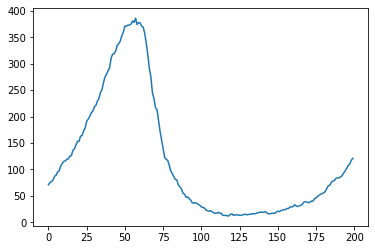

In [2]:
obs = problem.get_obs()
import matplotlib.pyplot as plt
plt.plot(obs['y'][:,0])

In [3]:
hs = []

for distance, label in zip(distances, labels):
    print(label)
    abc = ABCSMC(problem.get_model(), problem.get_prior(), distance, population_size=1000)
    abc.new(pyabc.create_sqlite_db_id(), problem.get_obs())
    h = abc.run(max_total_nr_simulations=50e3)
    hs.append(h)

INFO:Sampler:Parallelizing the sampling on 4 cores.


Euclidean


INFO:History:Start <ABCSMC id=243, start_time=2021-04-20 10:40:15.157042>
INFO:ABC:Calibration sample t=-1.
INFO:Epsilon:initial epsilon is 3322.950044211156
INFO:ABC:t: 0, eps: 3322.950044211156.
INFO:ABC:Acceptance rate: 200 / 430 = 4.6512e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 3262.9850595642793.
INFO:ABC:Acceptance rate: 200 / 480 = 4.1667e-01, ESS=1.5222e+02.
INFO:ABC:t: 2, eps: 3225.1989249082358.
INFO:ABC:Acceptance rate: 200 / 464 = 4.3103e-01, ESS=1.4982e+02.
INFO:History:Done <ABCSMC id=243, duration=0:00:07.645056, end_time=2021-04-20 10:40:22.802098>


KeyboardInterrupt: 

/home/yannik/pyabc/pyabc/visualization/sample.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

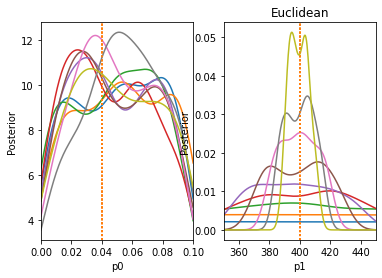

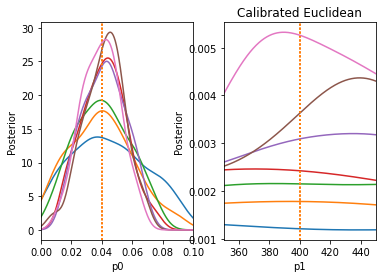

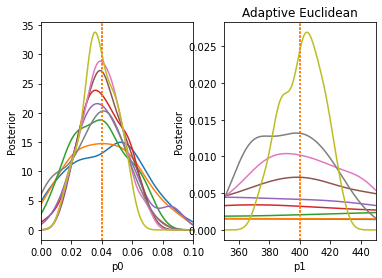

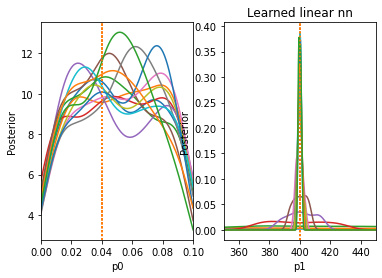

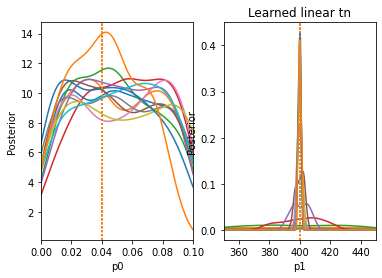

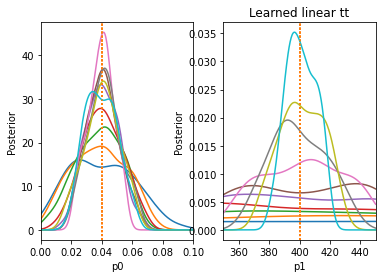

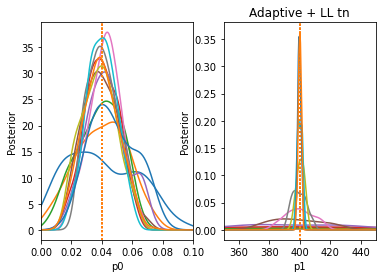

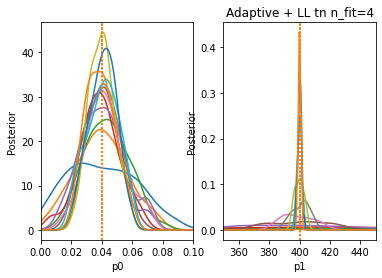

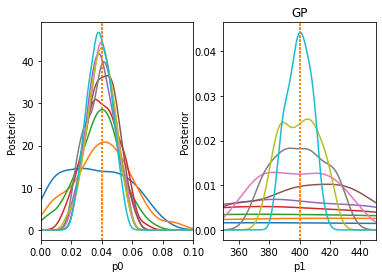

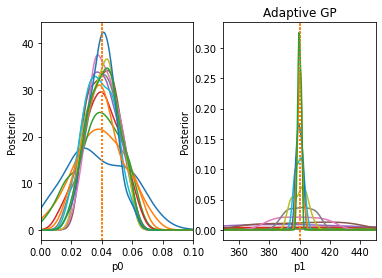

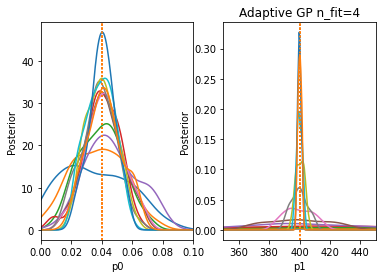

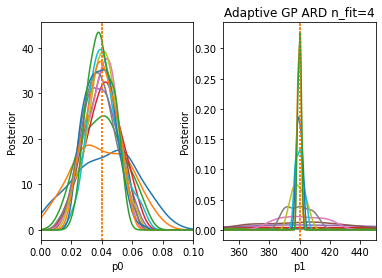

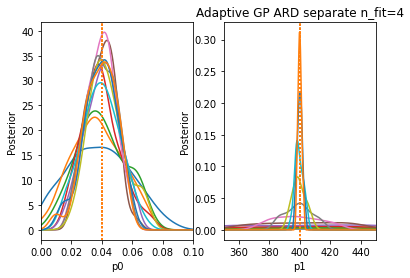

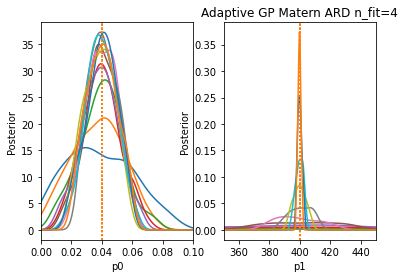

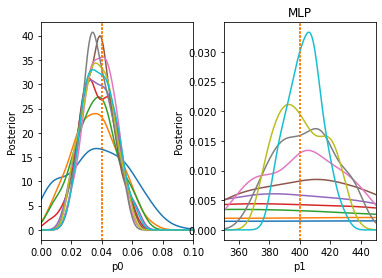

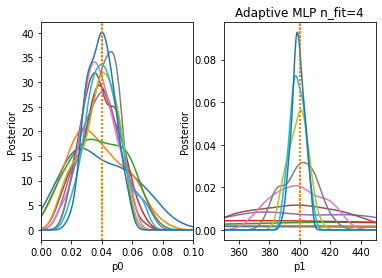

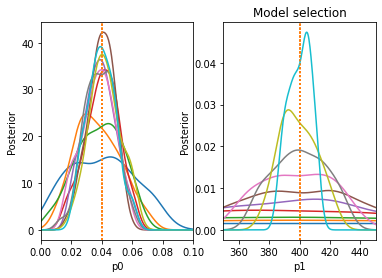

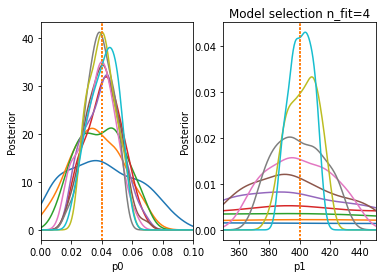

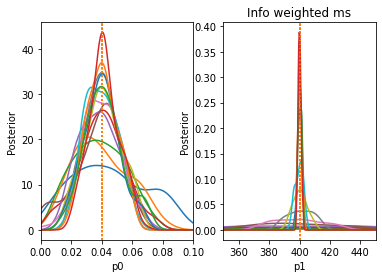

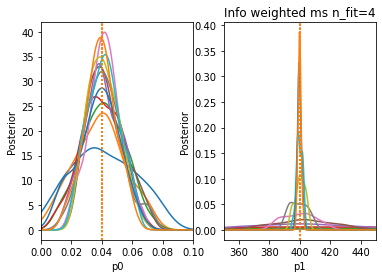

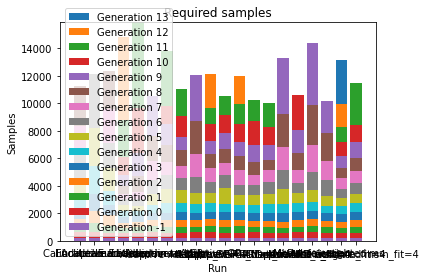

In [3]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

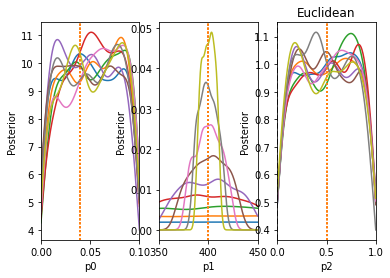

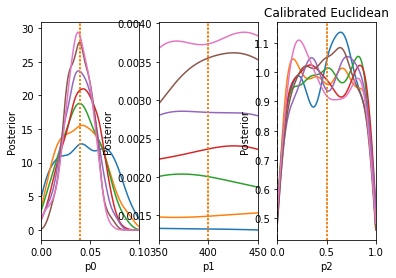

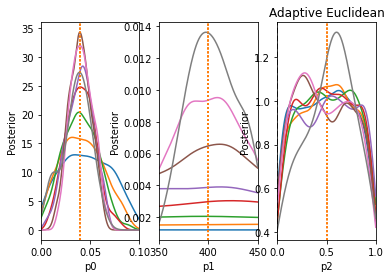

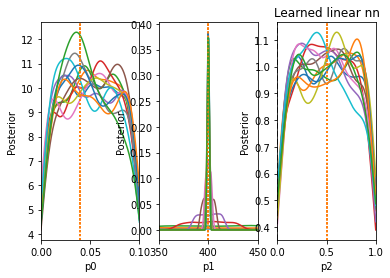

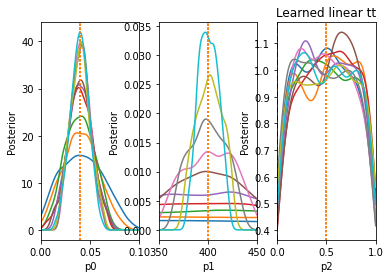

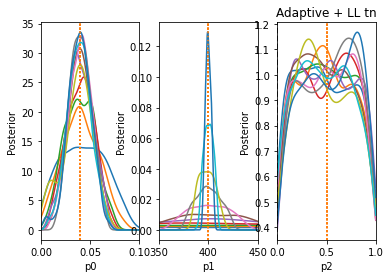

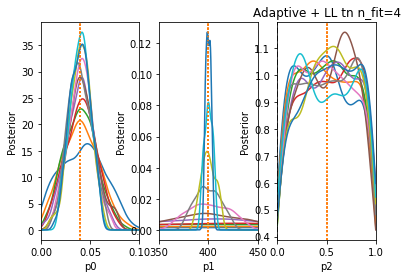

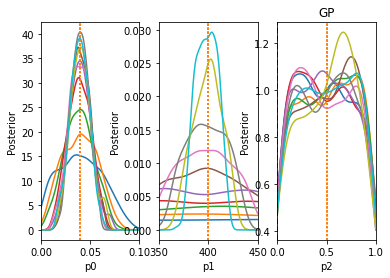

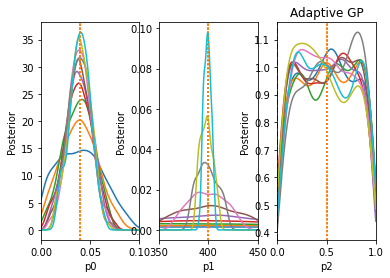

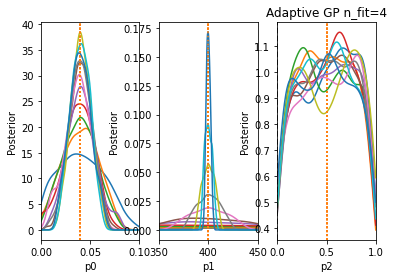

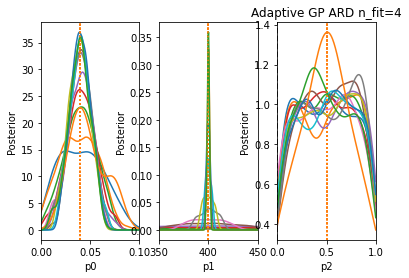

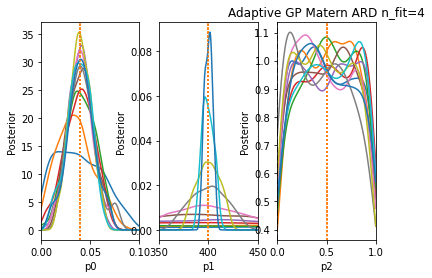

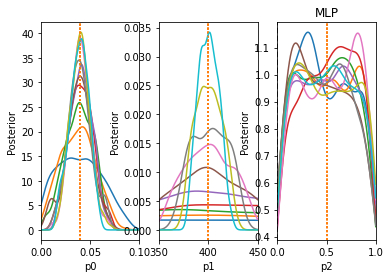

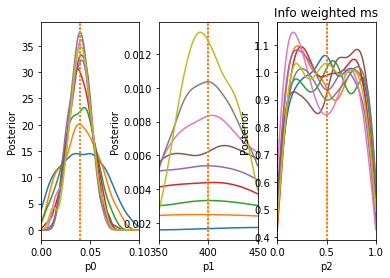

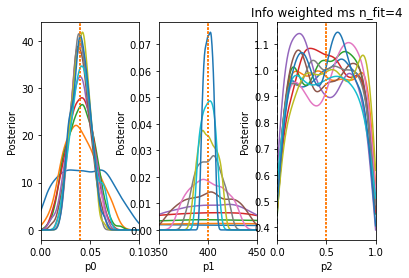

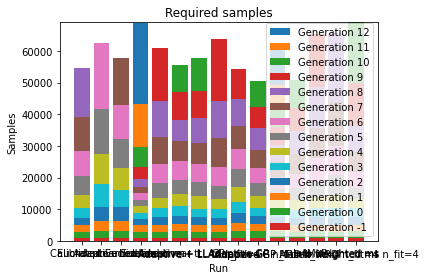

In [13]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

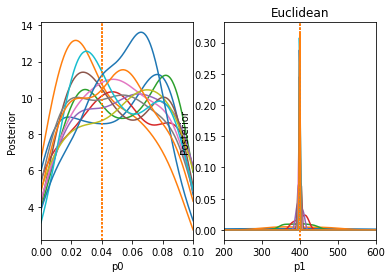

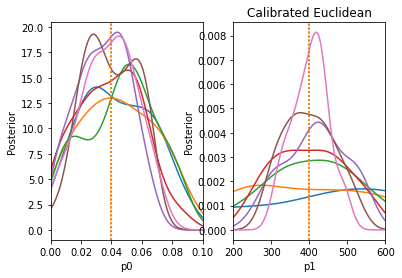

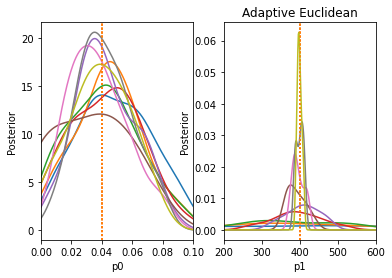

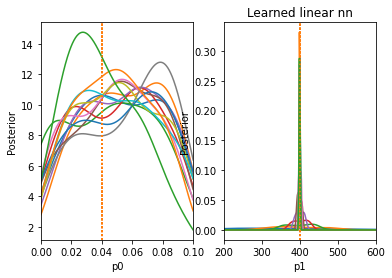

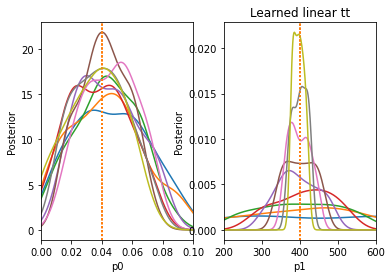

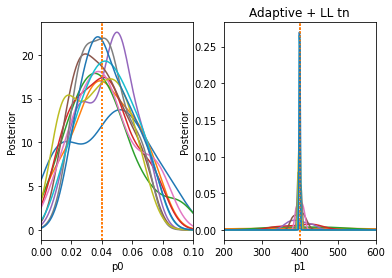

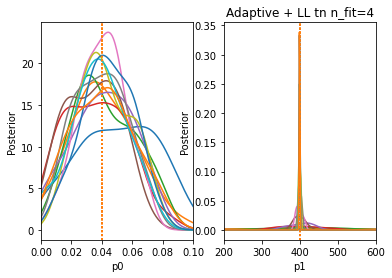

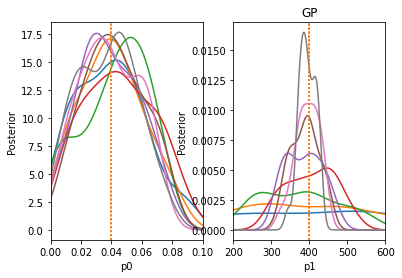

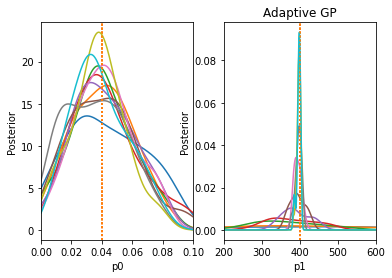

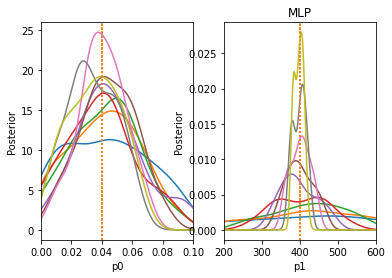

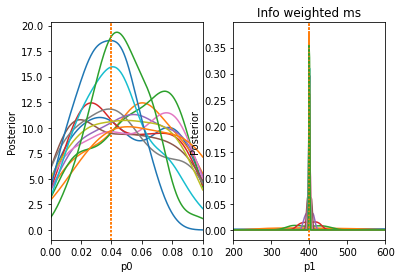

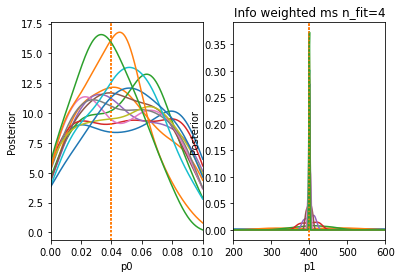

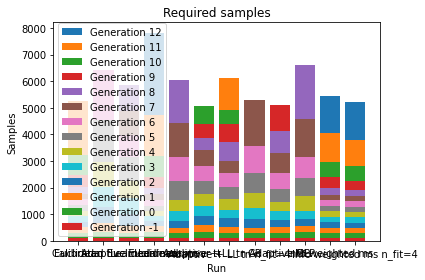

In [7]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)